In [1]:
#reference GAN https://github.com/daymos/simple_keras_GAN/blob/master/gan.py
#reference WGAN https://github.com/eriklindernoren/Keras-GAN/blob/master/wgan/wgan.py

In [11]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop

import keras.backend as K

import matplotlib.pyplot as plt

import sys

import numpy as np

class WGAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        self.g_loss = []
        self.d_loss = []

        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        self.clip_value = 0.01
        optimizer = RMSprop(lr=0.00005)

        # Build and compile the critic
        self.critic = self.build_critic()
        self.critic.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generated imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.critic.trainable = False

        # The critic takes generated images as input and determines validity
        valid = self.critic(img)

        # The combined model  (stacked generator and critic)
        self.combined = Model(z, valid)
        self.combined.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=4, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_critic(self):

        model = Sequential()

        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (X_test, _) = mnist.load_data()
        X_train = X_test

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = -np.ones((batch_size, 1))
        fake = np.ones((batch_size, 1))

        for epoch in range(epochs):

            for _ in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                
                # Sample noise as generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Generate a batch of new images
                gen_imgs = self.generator.predict(noise)

                # Train the critic
                d_loss_real = self.critic.train_on_batch(imgs, valid)
                d_loss_fake = self.critic.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

                # Clip critic weights
                for l in self.critic.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                    l.set_weights(weights)


            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f] [G loss: %f]" % (epoch, 1 - d_loss[0], 1 - g_loss[0]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)
                
            self.g_loss.append(g_loss)
            self.d_loss.append(d_loss)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 1

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/mnist_%d.png" % epoch)
        plt.close()

In [12]:
wgan = WGAN()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 14, 14, 16)        160       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 7, 32)          4640      
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 8, 8, 32)          0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 8, 8, 32)          128       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 8, 8, 32)          0         
__________

In [13]:
wgan.train(epochs=1000, batch_size=32, sample_interval=50)

C:\Users\Sophie\Anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.999924] [G loss: 1.000163]
1 [D loss: 0.999928] [G loss: 1.000163]
2 [D loss: 0.999935] [G loss: 1.000170]
3 [D loss: 0.999932] [G loss: 1.000166]
4 [D loss: 0.999935] [G loss: 1.000166]
5 [D loss: 0.999934] [G loss: 1.000167]
6 [D loss: 0.999938] [G loss: 1.000171]
7 [D loss: 0.999938] [G loss: 1.000165]
8 [D loss: 0.999931] [G loss: 1.000177]
9 [D loss: 0.999931] [G loss: 1.000162]
10 [D loss: 0.999944] [G loss: 1.000167]
11 [D loss: 0.999939] [G loss: 1.000161]
12 [D loss: 0.999940] [G loss: 1.000157]
13 [D loss: 0.999935] [G loss: 1.000134]
14 [D loss: 0.999946] [G loss: 1.000139]
15 [D loss: 0.999937] [G loss: 1.000134]
16 [D loss: 0.999941] [G loss: 1.000135]
17 [D loss: 0.999946] [G loss: 1.000111]
18 [D loss: 0.999946] [G loss: 1.000111]
19 [D loss: 0.999938] [G loss: 1.000102]
20 [D loss: 0.999946] [G loss: 1.000093]
21 [D loss: 0.999952] [G loss: 1.000081]
22 [D loss: 0.999948] [G loss: 1.000099]
23 [D loss: 0.999959] [G loss: 1.000093]
24 [D loss: 0.999955] [G l

198 [D loss: 0.999972] [G loss: 1.000075]
199 [D loss: 0.999970] [G loss: 1.000068]
200 [D loss: 0.999970] [G loss: 1.000065]
201 [D loss: 0.999980] [G loss: 1.000062]
202 [D loss: 0.999968] [G loss: 1.000070]
203 [D loss: 0.999974] [G loss: 1.000051]
204 [D loss: 0.999960] [G loss: 1.000076]
205 [D loss: 0.999968] [G loss: 1.000078]
206 [D loss: 0.999961] [G loss: 1.000081]
207 [D loss: 0.999968] [G loss: 1.000060]
208 [D loss: 0.999960] [G loss: 1.000065]
209 [D loss: 0.999967] [G loss: 1.000073]
210 [D loss: 0.999967] [G loss: 1.000062]
211 [D loss: 0.999969] [G loss: 1.000070]
212 [D loss: 0.999970] [G loss: 1.000063]
213 [D loss: 0.999963] [G loss: 1.000067]
214 [D loss: 0.999969] [G loss: 1.000067]
215 [D loss: 0.999974] [G loss: 1.000070]
216 [D loss: 0.999972] [G loss: 1.000062]
217 [D loss: 0.999968] [G loss: 1.000071]
218 [D loss: 0.999970] [G loss: 1.000070]
219 [D loss: 0.999967] [G loss: 1.000079]
220 [D loss: 0.999971] [G loss: 1.000071]
221 [D loss: 0.999975] [G loss: 1.

394 [D loss: 0.999973] [G loss: 1.000059]
395 [D loss: 0.999970] [G loss: 1.000071]
396 [D loss: 0.999964] [G loss: 1.000068]
397 [D loss: 0.999971] [G loss: 1.000062]
398 [D loss: 0.999970] [G loss: 1.000072]
399 [D loss: 0.999965] [G loss: 1.000062]
400 [D loss: 0.999971] [G loss: 1.000054]
401 [D loss: 0.999960] [G loss: 1.000072]
402 [D loss: 0.999969] [G loss: 1.000062]
403 [D loss: 0.999976] [G loss: 1.000074]
404 [D loss: 0.999975] [G loss: 1.000063]
405 [D loss: 0.999961] [G loss: 1.000046]
406 [D loss: 0.999973] [G loss: 1.000061]
407 [D loss: 0.999969] [G loss: 1.000061]
408 [D loss: 0.999957] [G loss: 1.000066]
409 [D loss: 0.999964] [G loss: 1.000068]
410 [D loss: 0.999972] [G loss: 1.000048]
411 [D loss: 0.999966] [G loss: 1.000064]
412 [D loss: 0.999964] [G loss: 1.000065]
413 [D loss: 0.999963] [G loss: 1.000050]
414 [D loss: 0.999970] [G loss: 1.000069]
415 [D loss: 0.999969] [G loss: 1.000070]
416 [D loss: 0.999967] [G loss: 1.000067]
417 [D loss: 0.999967] [G loss: 1.

590 [D loss: 0.999976] [G loss: 1.000065]
591 [D loss: 0.999971] [G loss: 1.000055]
592 [D loss: 0.999969] [G loss: 1.000064]
593 [D loss: 0.999977] [G loss: 1.000062]
594 [D loss: 0.999978] [G loss: 1.000058]
595 [D loss: 0.999968] [G loss: 1.000069]
596 [D loss: 0.999968] [G loss: 1.000064]
597 [D loss: 0.999963] [G loss: 1.000069]
598 [D loss: 0.999970] [G loss: 1.000059]
599 [D loss: 0.999972] [G loss: 1.000066]
600 [D loss: 0.999972] [G loss: 1.000064]
601 [D loss: 0.999975] [G loss: 1.000069]
602 [D loss: 0.999968] [G loss: 1.000064]
603 [D loss: 0.999972] [G loss: 1.000062]
604 [D loss: 0.999973] [G loss: 1.000065]
605 [D loss: 0.999968] [G loss: 1.000068]
606 [D loss: 0.999969] [G loss: 1.000075]
607 [D loss: 0.999974] [G loss: 1.000064]
608 [D loss: 0.999969] [G loss: 1.000064]
609 [D loss: 0.999968] [G loss: 1.000068]
610 [D loss: 0.999964] [G loss: 1.000064]
611 [D loss: 0.999966] [G loss: 1.000061]
612 [D loss: 0.999971] [G loss: 1.000071]
613 [D loss: 0.999975] [G loss: 1.

786 [D loss: 0.999966] [G loss: 1.000068]
787 [D loss: 0.999963] [G loss: 1.000067]
788 [D loss: 0.999968] [G loss: 1.000065]
789 [D loss: 0.999972] [G loss: 1.000062]
790 [D loss: 0.999959] [G loss: 1.000066]
791 [D loss: 0.999966] [G loss: 1.000069]
792 [D loss: 0.999971] [G loss: 1.000056]
793 [D loss: 0.999963] [G loss: 1.000059]
794 [D loss: 0.999971] [G loss: 1.000064]
795 [D loss: 0.999969] [G loss: 1.000067]
796 [D loss: 0.999976] [G loss: 1.000045]
797 [D loss: 0.999970] [G loss: 1.000064]
798 [D loss: 0.999971] [G loss: 1.000061]
799 [D loss: 0.999970] [G loss: 1.000061]
800 [D loss: 0.999971] [G loss: 1.000069]
801 [D loss: 0.999974] [G loss: 1.000062]
802 [D loss: 0.999966] [G loss: 1.000058]
803 [D loss: 0.999973] [G loss: 1.000055]
804 [D loss: 0.999962] [G loss: 1.000069]
805 [D loss: 0.999976] [G loss: 1.000059]
806 [D loss: 0.999975] [G loss: 1.000055]
807 [D loss: 0.999970] [G loss: 1.000066]
808 [D loss: 0.999972] [G loss: 1.000057]
809 [D loss: 0.999975] [G loss: 1.

982 [D loss: 0.999967] [G loss: 1.000062]
983 [D loss: 0.999968] [G loss: 1.000052]
984 [D loss: 0.999966] [G loss: 1.000061]
985 [D loss: 0.999968] [G loss: 1.000070]
986 [D loss: 0.999960] [G loss: 1.000075]
987 [D loss: 0.999970] [G loss: 1.000066]
988 [D loss: 0.999975] [G loss: 1.000057]
989 [D loss: 0.999969] [G loss: 1.000069]
990 [D loss: 0.999971] [G loss: 1.000074]
991 [D loss: 0.999974] [G loss: 1.000056]
992 [D loss: 0.999971] [G loss: 1.000059]
993 [D loss: 0.999965] [G loss: 1.000065]
994 [D loss: 0.999968] [G loss: 1.000056]
995 [D loss: 0.999968] [G loss: 1.000064]
996 [D loss: 0.999968] [G loss: 1.000076]
997 [D loss: 0.999975] [G loss: 1.000068]
998 [D loss: 0.999971] [G loss: 1.000060]
999 [D loss: 0.999967] [G loss: 1.000068]


In [14]:
def plotLoss(train, test):
    iterations = list(range(len(train)))
    plt.plot(iterations, train, label="Discriminator")
    plt.plot(iterations, test, label="Generator")       

    plt.xlabel("Number of Iterations")
    plt.ylabel("Loss")
    plt.grid(True, linestyle='dotted')
    plt.legend() #loc="upper left"

    plt.show()

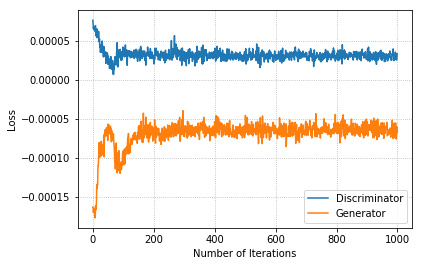

In [16]:
dloss = [x[0] for x in wgan.d_loss]
gloss = [x[0] for x in wgan.g_loss]
plotLoss(dloss, gloss)

In [ ]:
def photogallery(photos):
    fig = plt.figure(figsize=(4, 12))
    for i, entry in enumerate(photos):
        ax1 = fig.add_subplot(10,2,i*2+1)
        ax1.imshow(entry[0])
        ax2 = fig.add_subplot(10,2,i*2+2)
        ax2.imshow(entry[1])

In [ ]:
np.random.seed(42)
digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
photos = []

print("original, vae")
for digit in digits:
    index0 = np.where(y_test==digit)[0]
    pick = index0[np.random.choice(index0.shape[0])]
    #digit_indexes.append(pick)
    #print(pick)
    #print(im_shape)
    original = x_test[pick].reshape(32, 32, 3)
    encoded = x_test_encoded[pick].reshape(32, 32,3)
    photos.append([original, encoded])
    
photogallery(photos)

In [35]:
def plotGeneratedImages(epoch, examples=40, dim=(10, 4), figsize=(10, 4)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure()
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap=plt.cm.gray)
        plt.axis('off')
    #plt.tight_layout()
    plt.show()
    #plt.savefig('images/gan_generated_image_epoch_%d.png' % epoch)

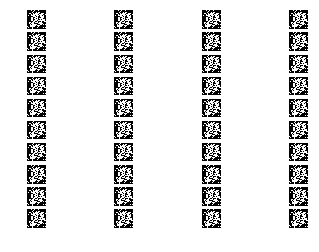

In [36]:
plotGeneratedImages(50)